In [36]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import seaborn as sns
import pandas as pd
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK, Trials
import time

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Input, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras import datasets, layers, models

from keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, RMSprop
from keras.datasets import fashion_mnist

sns.set_theme(font_scale=1.7, style='whitegrid')

# Esercitazione 4

## 4.0 - Appunti e introduzione

- In `C++` esiste la libreria `openMP` o `MPI`: passaggio di istruzioni precise, thread per thread;
- `Numba` usa in automatico `openMP`, altrimenti possiamo selezionare un `backend` tra quelli disponibili (vedi sito);

#### GPU

Un botto di threads ma:
- alto consumo di potenza e temperature piu' alto;
- singolo thread molto piu' lento della CPU: si punta sulla quantita' e non sulla qualita';
- RAM molto limitata. Abbiamo un tetto max di  80Gb ad oggi. In certi casi questo risulta limitante: bisogna lavorare bene con la memoria (meglio ricalcolare che conservare?);
- difficile costruzione e compilatori ad hoc forniti dai costruttori.

TensorFlow ricorre alla GPU tramite `cuda`

#### Torniamo a Keras

- `model.compile` accetta anche le stringhe (in quel caso non posso passare argomenti);
- `history.history` e' un dizionario;
- `model.evaluate` calcola le metriche al tempo corrente;
- `model.predict` effettua la predizione $NN(input_{new})=output_{new}$

#### Hyperopt

Possiamo fare random search, SMBO o Adaptive TPE (tipicamente il secondo). 

In [4]:
# variabili di supporto per la ricerca

space = hp.uniform('x', -10, 10)

b = hp.choice('b', [1,2,3,4])
c = hp.loguniform('c', -5, 0)

In [6]:
# tutto il fit del modello scelto sta qua
def objective(x):
    return x**2

# mi salvo la combo migliore tra tutte: piu' vado vicino allo zero meglio e'
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print(best)

100%|███| 100/100 [00:00<00:00, 580.04trial/s, best loss: 0.0013137379131258745]
{'x': 0.036245522663163166}


In [10]:
print(space_eval(space, best))

0.036245522663163166


In [17]:
# ma potrebbe interessarmi la grid completa, lo storico invece che la sola funzione in objective
def objective(x):
    return {'loss': x**2, 'status': STATUS_OK, 'eval_time': time.time()}

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

100%|█████| 100/100 [00:00<00:00, 573.49trial/s, best loss: 0.00871063994575528]
{'x': -0.0933308091990811}


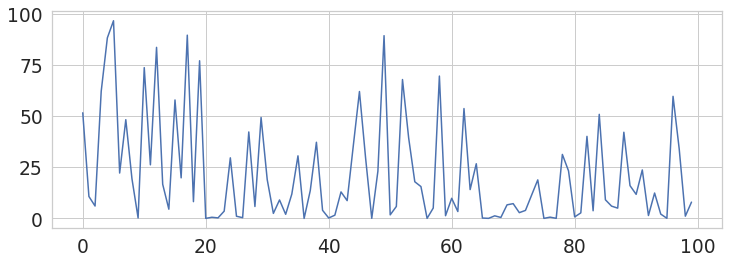

In [25]:
plt.figure(figsize=(12,4))
plt.plot(trials.losses())
plt.show()

Attenzione alla memoria. Questo approccio salva tutti i dati.

## 4.2 Data classification

In [75]:
img_rows, img_cols = 28, 28 
num_classes = 10 
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


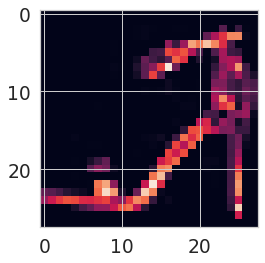

In [49]:
#rnd = np.random.uniform(0,60000, 10)
#or i in rnd: i=int(i)
    
plt.imshow(X_train[8])

In [34]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [95]:
def spawn_NN(opt):
    """ Spawn a DNN, this is my first comment #amazing
    
        Args: 
        opt(keras.optimizer) : your choice about the optimizer
    """
    NN = Sequential()
    NN.add(Flatten())
    NN.add(Dense(128, activation='relu'))
    NN.add(Dense(10, activation='softmax'))
    NN.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
    return NN

In [61]:
myNN = spawn_NN('adam')

In [62]:
history_fashion = myNN.fit(x=X_train, y=Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 3.9610 - accuracy: 0.6826 - val_loss: 0.8181 - val_accuracy: 0.6909
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7160 - accuracy: 0.7257 - val_loss: 0.6614 - val_accuracy: 0.7625
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6023 - accuracy: 0.7775 - val_loss: 0.6355 - val_accuracy: 0.7656
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5435 - accuracy: 0.8133 - val_loss: 0.5585 - val_accuracy: 0.8158
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5105 - accuracy: 0.8253 - val_loss: 0.6311 - val_accuracy: 0.7980
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5023 - accuracy: 0.8303 - val_loss: 0.5507 - val_accuracy: 0.8137
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4877 - accuracy: 0.8364 - val_loss: 0.5595 - val_accuracy:

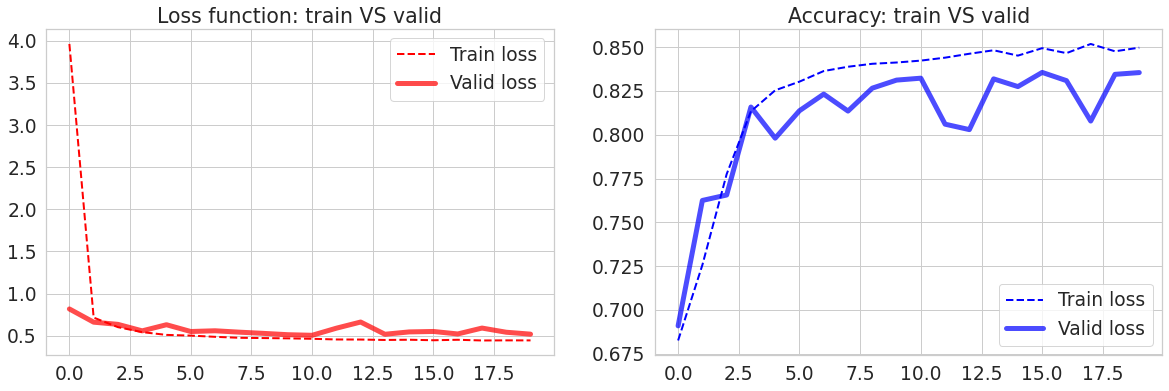

In [69]:
ep = np.arange(20)

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Loss function: train VS valid')
plt.plot(ep, history_fashion.history['loss'], color='red', ls='--', lw=2, label='Train loss')
plt.plot(ep, history_fashion.history['val_loss'], color='red', ls='-', lw=5, label='Valid loss', alpha=0.7)
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy: train VS valid')
plt.plot(ep, history_fashion.history['accuracy'], color='blue', ls='--', lw=2, label='Train loss')
plt.plot(ep, history_fashion.history['val_accuracy'], color='blue', ls='-', lw=5, label='Valid loss', alpha=0.7)
plt.legend()
plt.show()

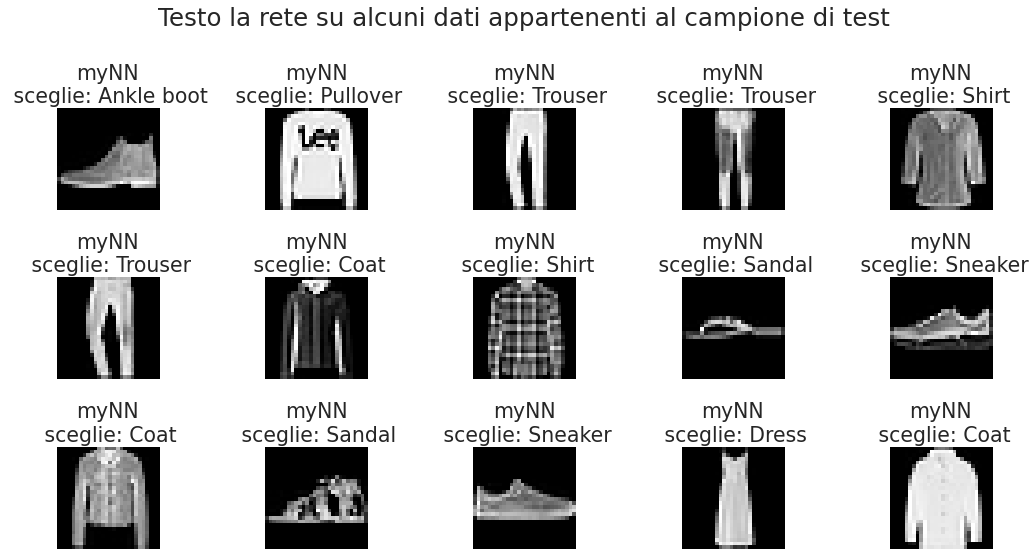

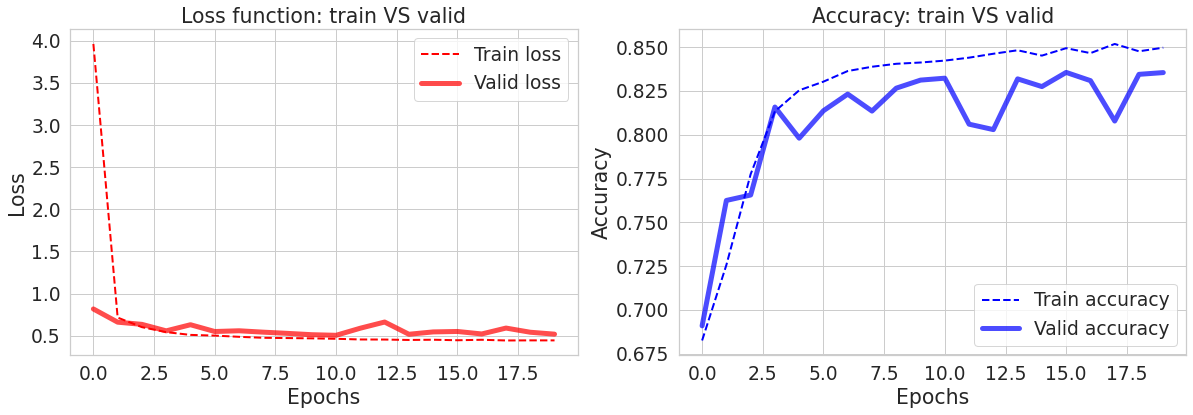

In [102]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = myNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)


plt.figure(figsize=(15, 8)) 
plt.suptitle('Testo la rete su alcuni dati appartenenti al campione di test')

for i in range(15):    
    ax = plt.subplot(3, 5, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("myNN\n sceglie: "+labels[np.argmax(predictions[i])])    
    plt.axis('off') 
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Loss function: train VS valid')
plt.plot(ep, history_fashion.history['loss'], color='red', ls='--', lw=2, label='Train loss')
plt.plot(ep, history_fashion.history['val_loss'], color='red', ls='-', lw=5, label='Valid loss', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy: train VS valid')
plt.plot(ep, history_fashion.history['accuracy'], color='blue', ls='--', lw=2, label='Train accuracy')
plt.plot(ep, history_fashion.history['val_accuracy'], color='blue', ls='-', lw=5, label='Valid accuracy', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()